<center>
    
# DT00BQ89 

# Multidimensional Sensing Techniques

## Lab exercise 1 - Step counter

## Petteri Laitinen ÅA 21965
## Harri Kemppainen ÅA 1801751
### 23.9.2019
</center>

#### Import necessary libraries

In [173]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate

#### Plotting function - no changes

In [214]:
def draw_original_signals(timestamps, x_arr,y_arr,z_arr):
    plt.figure(1,figsize=(20,10))
    plt.plot(timestamps, x_arr, color = "blue",linewidth=1.0)
    plt.plot(timestamps, y_arr, color = "red",linewidth=1.0)
    plt.plot(timestamps, z_arr, color = "green",linewidth=1.0)
    plt.show()


In [215]:
#Simple function to visualize 4 arrays that are given to it
def visualize_data(timestamps, x_arr,y_arr,z_arr,s_arr, option):
    #Plot original accelerometer readings

    plt.figure(2,figsize=(20,10))
    #plotting magnitude and steps
    plt.plot(timestamps, s_arr, color = "black",marker="o",linewidth=1.0)
    plt.plot(timestamps, aggregate_signals(x_arr,y_arr,z_arr, option)[0], color = "red",linewidth=1.0)
    plt.title(aggregate_signals(x_arr,y_arr,z_arr, option)[1])
    plt.show()

#### Function to read the data from the log file
We ended up using pandas library to import the data.

In [139]:
#Function to read the data from the log file
#We read in first column to time stamps, second to x, third to y and fourth to z
def read_data(filename):
    '''Ensure that data has four columns, no headers and semicolon as delimiter'''
    df=pd.read_csv(filename,header=None,delimiter=';',dtype=int)
    timestamps=df[0].to_numpy()
    x_array=df[1].to_numpy()
    y_array=df[2].to_numpy()
    z_array=df[3].to_numpy()
    return timestamps, x_array, y_array, z_array

#### Function that counts steps
First version is very simple, it 
* first selects the dimension where accelerator variance is maximum (assumed that this is the vertical dimension, or closest to vertical dimension),
* second compares current value with maximum value of window of 1000 units both onwards and backwards, 
* third, if the current value is highest (peak), the time is stored,
* exception that if the previous peak was within the window length, the current peak is omitted.

This is sensitive to measurement frequency (sampling rate), too wide window will underestimate number of steps. Not sure if 500 units works!

In [211]:
def aggregate_signals(x_arr,y_arr,z_arr, option):
    '''option 1: signal with highest variation (x or y or z)
    option 2: sum of signals
    option 3: gradient of sum of signals
    option 4: Magnitude 
    option 5: Gradient of magnitude
    option 6: Magnitude of gradients'''
    #1 Calculate variations of x,y and z movement:
    ''' option 1: signal with highest variation (x or y or z)'''
    if option==1:
        x_std=np.std(x_arr)
        y_std=np.std(y_arr)
        z_std=np.std(z_arr)
        if x_std>y_std and x_std>z_std:
            verticaldata=x_arr
        if y_std>x_std and y_std>z_std:
            verticaldata=y_arr
        if z_std>x_std and z_std>y_std:
            verticaldata=z_arr
        finaldata=verticaldata
        label='option 1: signal with highest variation (x or y or z)'
    ''' option 2: sum of signals'''
    if option==2:
        finaldata=np.abs(x_arr+y_arr+z_arr)
        label='option 2: absolute of sum of signals'
    ''' option 3: gradient of absolute of sum of signals'''
    if option==3:
        finaldata=np.gradient(np.abs(x_arr+y_arr+z_arr))
        label='option 3: gradient of absolute of sum of signals'
    ''' option 4: Magnitude '''
    if option==4:
        finaldata=np.linalg.norm([x_arr,y_arr,z_arr],axis=0)
        label='option 4: Magnitude'
    ''' option 5: Absolute value of gradient of magnitude'''
    if option==5:
        finaldata=np.abs(np.gradient(np.linalg.norm([x_arr,y_arr,z_arr],axis=0)))
        label='option 5: Absolute value of gradient of magnitude'
    ''' option 6: Magnitude of gradients'''
    if option==6:
        finaldata=np.linalg.norm([np.gradient(x_arr),np.gradient(y_arr),np.gradient(z_arr)],axis=0)
        label='option 6: Magnitude of gradients'
    '''option 7: trapezoid integral of sum of signals'''
    if option==7:
        x=(x_arr+y_arr+z_arr)
        finaldata= integrate.cumtrapz(x, np.linspace(0, len(x)-1, len(x)), initial=0)
        label='option 7: trapezoid integral of sum of signals'
    return finaldata,label

In [235]:
#Function to count steps.
#Should return an array of timestamps from when steps were detected
#Each value in this arrray should represent the time that step was made.
def count_steps(timestamps, x_arr, y_arr, z_arr,option,window):
    # 1 First, calculate aggregated data using one of the aggregation methods in a separate function 
    finaldata,description=aggregate_signals(x_arr,y_arr,z_arr,option)


    lastpeak=-9999999
    rv = []
    for i, time in enumerate(timestamps):
        # we try to look into a moving window of length window. 
        # If the current value is higher than any other in the window,
        # we append the time label
        # start and end of time series need a special windowing
        # Define the window:
        start=i-window
        end=i+window
        if i<window:
            start=0
            end=i+window
        if i>len(timestamps)-window:
            start=i-window
            end=len(timestamps)
        #3 Compare and append if we have a peak
        if finaldata[i]==np.max(finaldata[start:end]):
            #We only take first peak per window. If the previous one was within window, we skip the current one.
            if lastpeak<i-window:
                rv.append(time)
                lastpeak=i
        # The following is kept from the original code, should consider to remove it:    
        # Considered, and removed
        #if(i==0):
        #    rv.append(time)
    return rv


#### This function is not used anywhere
Is it a hint of how we should solve the problem?

In [204]:
#Calculate the magnitude of the given vector
def magnitude(x,y,z):
    return np.linalg.norm((x,y,z))




#### No changes to the step array generator

In [205]:
#Function to convert array of times where steps happened into array to give into graph visualization
#Takes timestamp-array and array of times that step was detected as an input
#Returns an array where each entry is either zero if corresponding timestamp has no step detected or 50000 if the step was detected
def generate_step_array(timestamps, step_time):
    s_arr = []
    ctr = 0
    for i, time in enumerate(timestamps):
        if(ctr<len(step_time) and step_time[ctr]<=time):
            ctr += 1
            s_arr.append( 50000 )
        else:
            s_arr.append( 0 )
    while(len(s_arr)<len(timestamps)):
        s_arr.append(0)
    return s_arr


#### No changes to array matching function

In [206]:
#Check that the sizes of arrays match
def check_data(t,x,y,z):
  if( len(t)!=len(x) or len(y)!=len(z) or len(x)!=len(y) ):
    print("Arrays of incorrect length")
    return False
  print("The amount of data read from accelerometer is "+str(len(t))+" entries")
  return True

#### Main program 
Remember to change

In [236]:

def main(input_file,option,plot_original_signals,window_size):
    #read data from a measurement file
    timestamps, x_array, y_array, z_array = read_data(input_file)
    if plot_original_signals:
        draw_original_signals(timestamps, x_array, y_array, z_array)
    #Check that the data does not produce errors
    if(not check_data(timestamps, x_array,y_array,z_array)):
        return

    #Count the steps based on array of measurements from accelerometer
    st = count_steps(timestamps, x_array, y_array, z_array,option,window_size)

    #Print the result
    print("This data contains "+str(len(st))+" steps according to current algorithm")
    
    #convert array of step times into graph-compatible format
    s_array = generate_step_array(timestamps, st)
    
    #visualize data and steps
    visualize_data(timestamps, x_array,y_array,z_array,s_array, option)
    return aggregate_signals(x_array,y_array,z_array, option)[1], str(len(st))

#### Call the main program
Test different methods of recognizing steps.

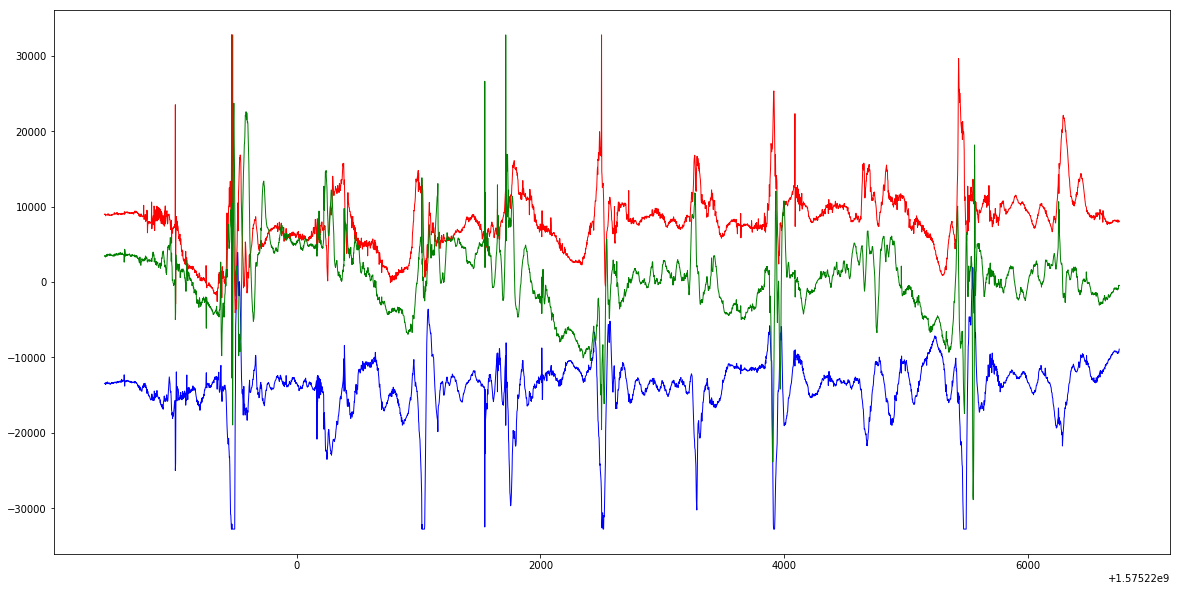

The amount of data read from accelerometer is 4005 entries
This data contains 12 steps according to current algorithm


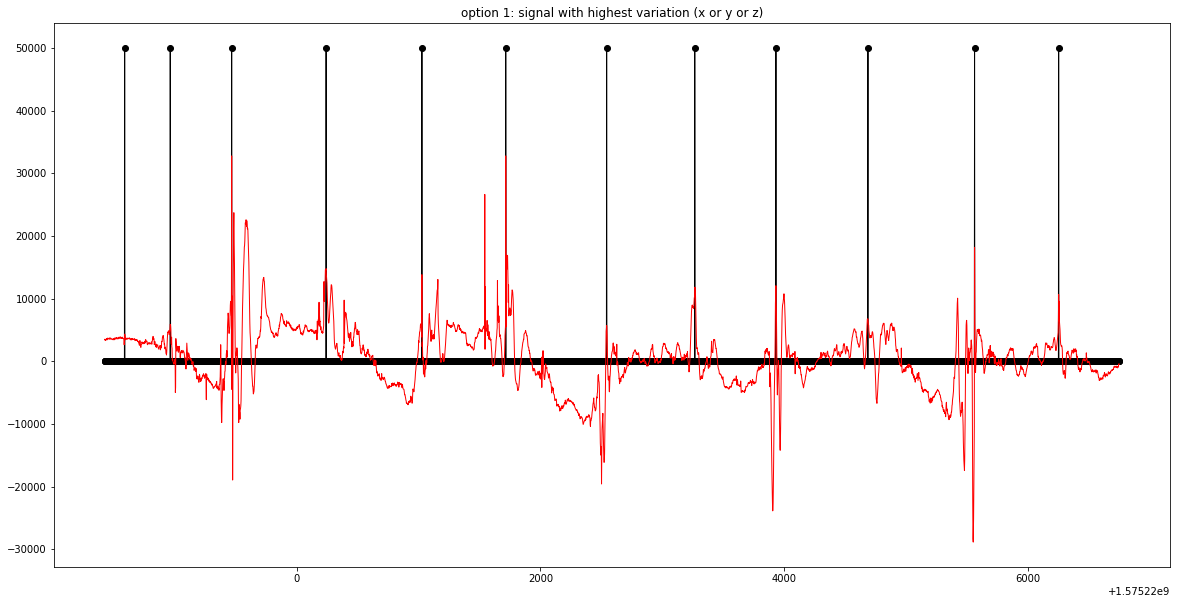

The amount of data read from accelerometer is 4005 entries
This data contains 13 steps according to current algorithm


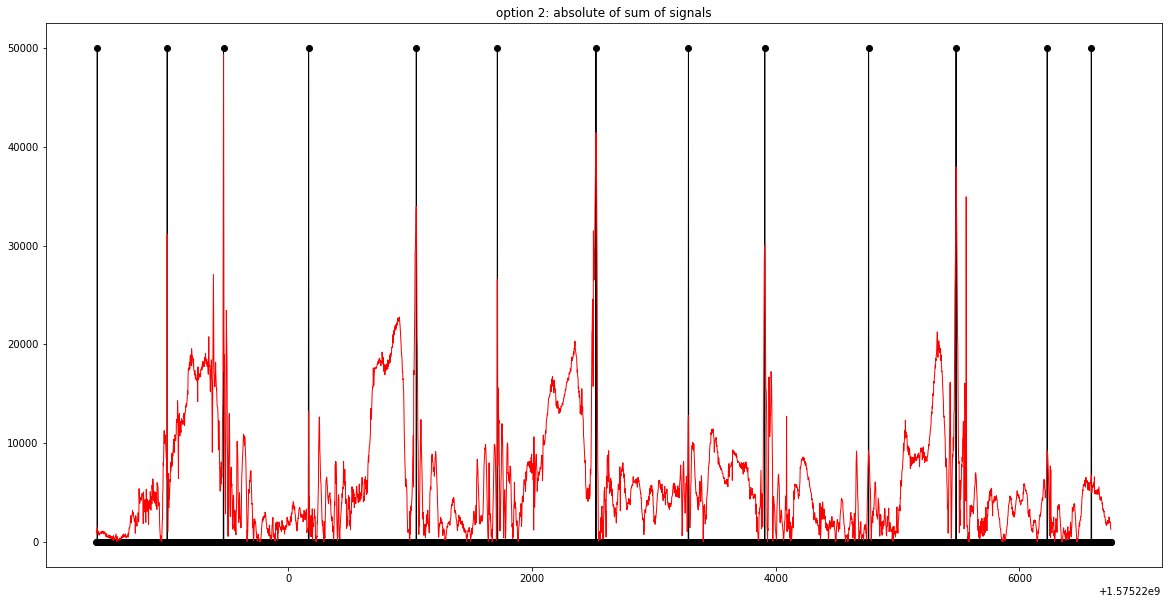

The amount of data read from accelerometer is 4005 entries
This data contains 13 steps according to current algorithm


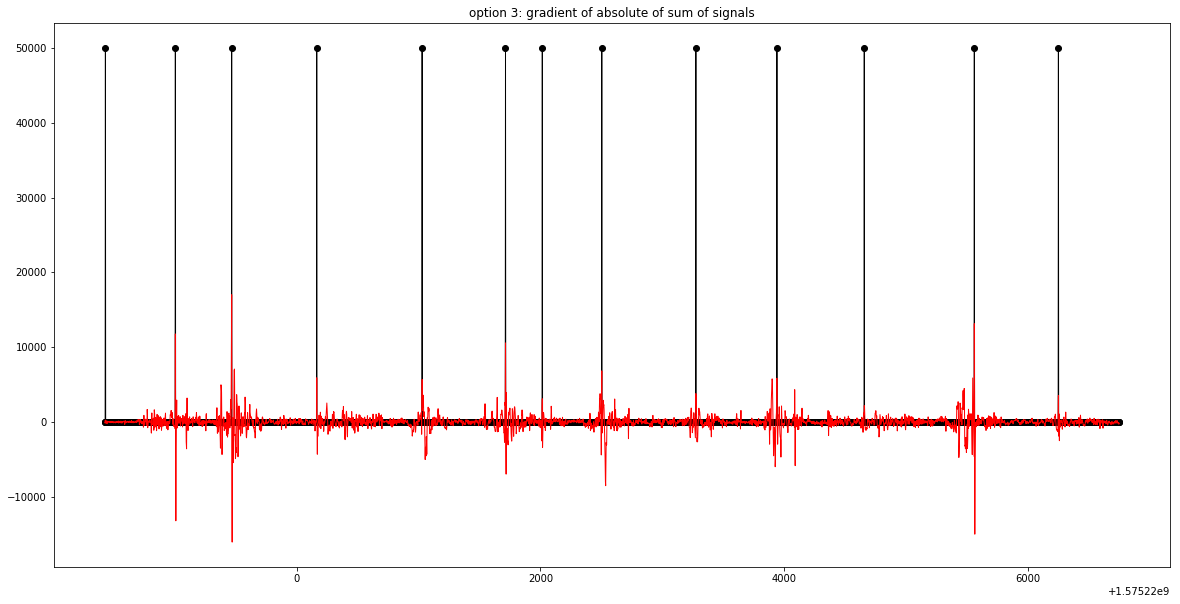

The amount of data read from accelerometer is 4005 entries
This data contains 11 steps according to current algorithm


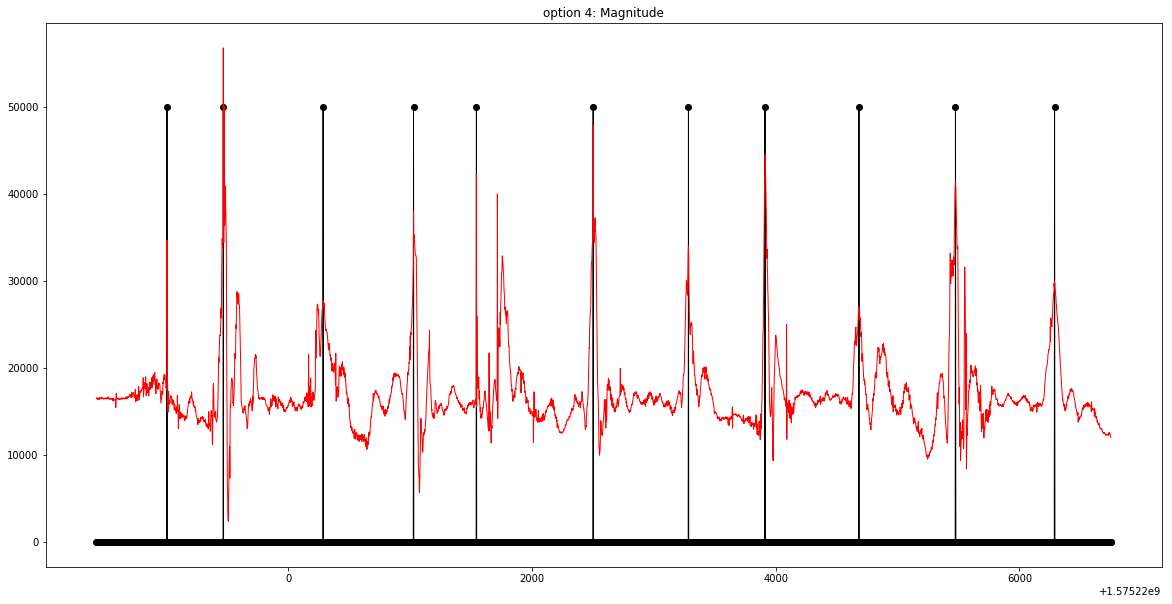

The amount of data read from accelerometer is 4005 entries
This data contains 13 steps according to current algorithm


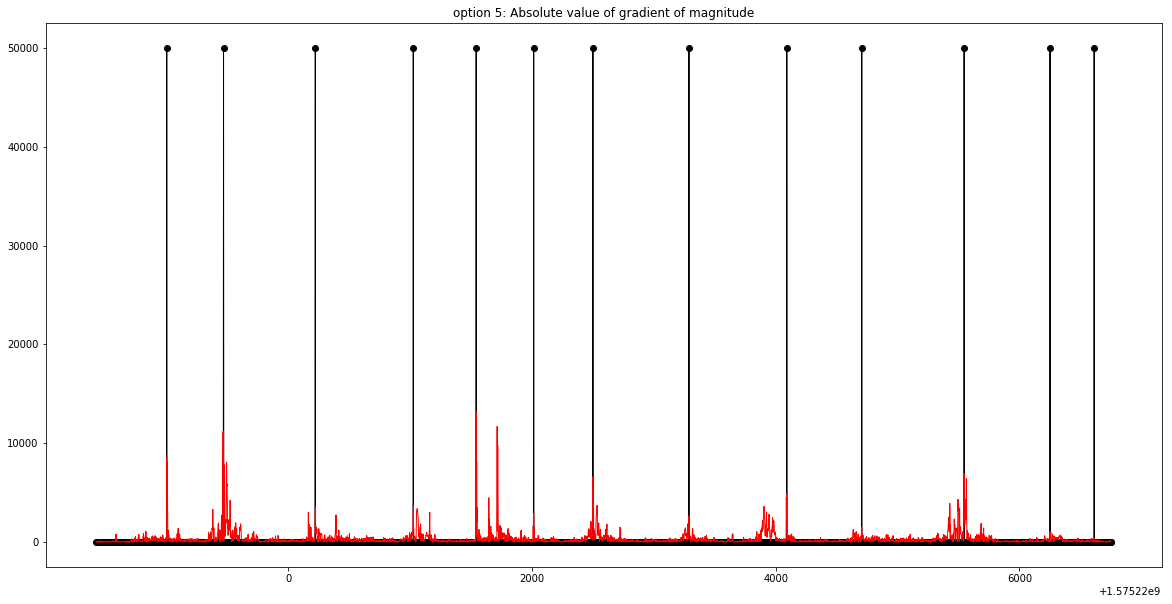

The amount of data read from accelerometer is 4005 entries
This data contains 14 steps according to current algorithm


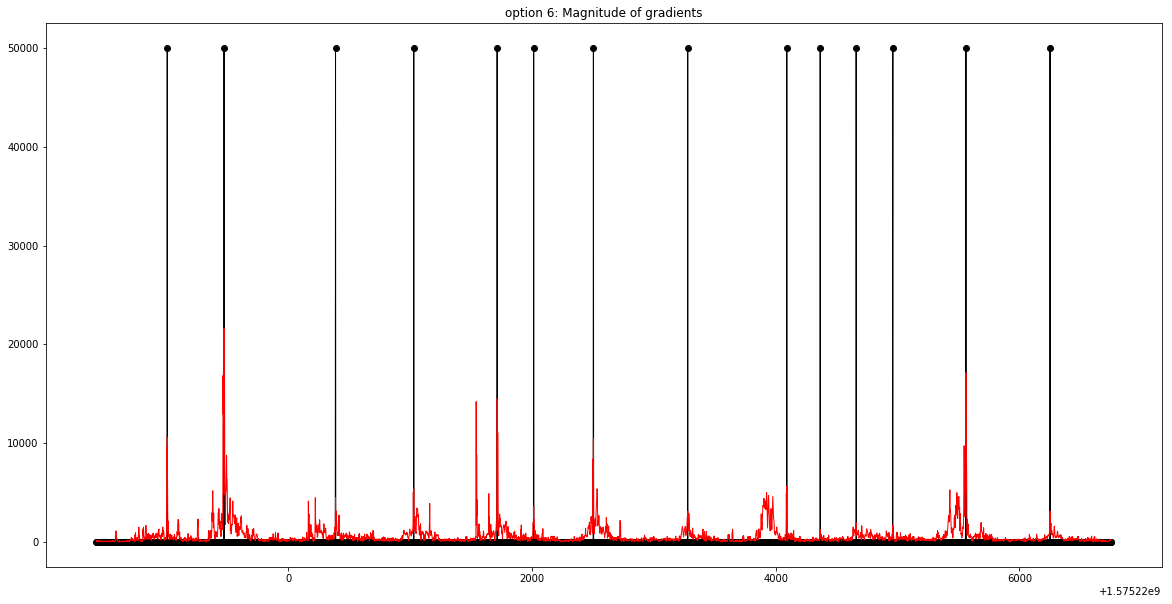

The amount of data read from accelerometer is 4005 entries
This data contains 2 steps according to current algorithm


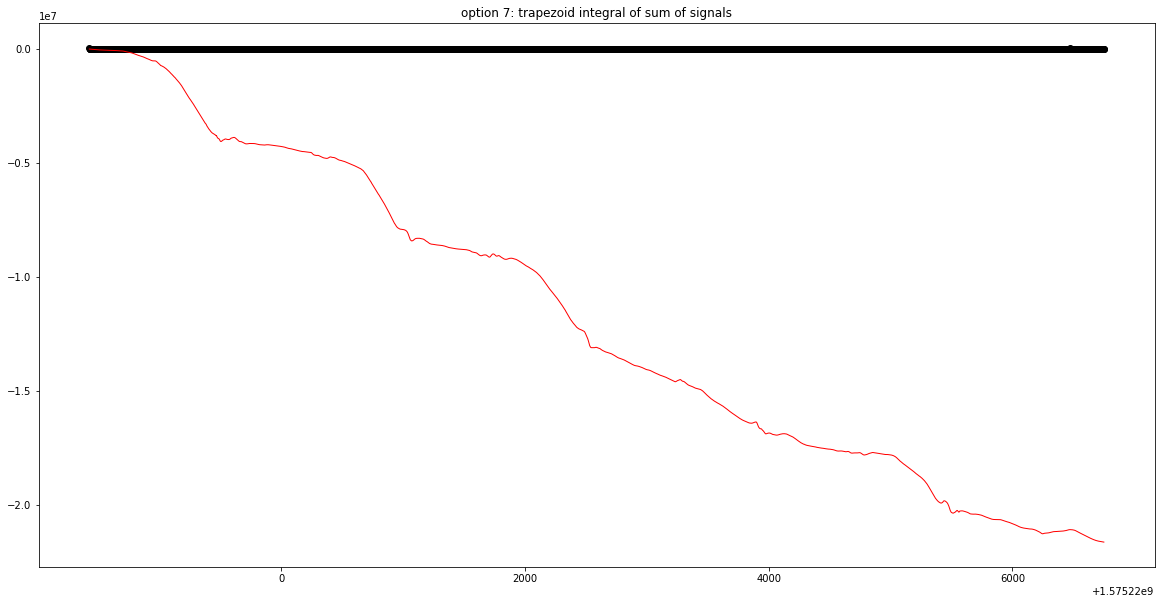

In [239]:
X=[]
X.append(main("accelerometer_data.csv",1,True,125))
for i in range(2,8,1):
    X.append(main("accelerometer_data.csv",i,False,125))

In [240]:
X

[('option 1: signal with highest variation (x or y or z)', '12'),
 ('option 2: absolute of sum of signals', '13'),
 ('option 3: gradient of absolute of sum of signals', '13'),
 ('option 4: Magnitude', '11'),
 ('option 5: Absolute value of gradient of magnitude', '13'),
 ('option 6: Magnitude of gradients', '14'),
 ('option 7: trapezoid integral of sum of signals', '2')]